In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd 
import numpy as np
import time
import glob
import os

from plotnine import *
from itertools import product
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

In [2]:
# Set seed
seed = 2024

# Control of which models are fitted if all code is run
fit_NNet = True
fit_RF = True
fit_deepNNet = True
fit_Lasso = False

# Data import

In [3]:
# Path to folder where data is stored in flat files
dataFolder = "/Users/sebastianbech/Desktop/Seminar - Asset prices and financial markets/Code/Data"

### Option chain data import
Link to source: https://www.optionsdx.com/product/spy-option-chains/?attribute_year=2023&attribute_quote-frequency=End+of+Day

In [4]:
# List of all option chains files
OC_dataFiles = glob.glob(os.path.join(dataFolder + '/option chains', "*.txt")) 

# Columns to be used
columns = {' [QUOTE_DATE]'      : 'Date',
           ' [UNDERLYING_LAST]' : 'underlyingLast', 
           ' [DTE]'             : 'DTE',            # Days till Expiry
           ' [C_IV]'            : 'c_sigma',
           ' [C_LAST]'          : 'c_last',
           ' [STRIKE]'          : 'strike'
}

# Read all datafiles into separate dataframes
OC_dataFiles_df = (pd.read_csv(file, 
                               low_memory=False,
                               delimiter = ',',
                               usecols = columns.keys(),
                               parse_dates = [' [QUOTE_DATE]'],
                               date_format='%Y-%m-%d'
                              ) for file in OC_dataFiles)

# Concat dataframes for all data files into one dataframe
option_df   = (pd.concat(OC_dataFiles_df, ignore_index=True)
               .rename(columns = columns)
               .map(lambda x: x.strip() if isinstance(x, str) else x)  # Remove all whitespace from string columns
               .apply(lambda col: pd.to_numeric(col, downcast='float', errors='ignore')) # Convert cols to optimal numeric datatype if possible                   
               .query('not (c_last == 0 and underlyingLast > strike)') # Excluding obs where no price is observed for in-the-money options
               .dropna()
               .astype({'Date':'str'})
               .set_index(['Date','strike'])
               .sort_index()
              )

print(f'Dataframe has {option_df.shape[0]:,} rows and {option_df.shape[1]} columns')


/var/folders/98/z1wc6yzj01v9l4vb81kbwc_w0000gn/T/ipykernel_13163/2080009367.py:26: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
/var/folders/98/z1wc6yzj01v9l4vb81kbwc_w0000gn/T/ipykernel_13163/2080009367.py:26: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
/var/folders/98/z1wc6yzj01v9l4vb81kbwc_w0000gn/T/ipykernel_13163/2080009367.py:26: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
/var/folders/98/z1wc6yzj01v9l4vb81kbwc_w0000gn/T/ipykernel_13163/2080009367.py:26: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
/var/folders/98/z1wc6yzj

Dataframe has 3,727,627 rows and 4 columns


### Yield curve data import
Link to source: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2021

Data validated against: https://www.ustreasuryyieldcurve.com

The files include data for the years 2020 to may 2024.

In [5]:
# List of all flat files containing yield curve data
yc_dataFiles = glob.glob(os.path.join(dataFolder + '/US yield curves', "*.csv")) 

# Read all datafiles into separate dataframes
yc_dataFiles_df = (pd.read_csv(file, 
                               low_memory=False, 
                               delimiter = ',',
                               parse_dates = ['Date'], 
                               date_format='%m/%d/%Y'
                              ) for file in yc_dataFiles)

# Concat dataframes for all data files into one dataframe
yield_curves = (pd.concat(yc_dataFiles_df, ignore_index=True)
                .astype({'Date':'str'})
                .set_index('Date')
                .astype('float32', errors='ignore') # Downscale from float64 to float32 to improve memory usage - can be reduced to float16 but this dtype can not represent two digits precisely hence it is a tradeoff between precision and computational efficiency
                .interpolate(axis=1) # Linearly interpolate missing curve points
                .sort_index()
                
              )

print(f'Dataframe has {yield_curves.shape[0]:,} rows and {yield_curves.shape[1]} columns')


Dataframe has 1,100 rows and 13 columns


### Join yield curves on option chain data

In [23]:
# Used for translating source names into names used in ML models
translation = {
    'underlyingLast'  : 'S',
    'strike'          : 'K',
    'DTE'             : 'T',
    'c_sigma'         : 'sigma',
    'c_last'          : 'observed_price'
}

# Join rates onto option chain data
mkt_data = (option_df.merge(yield_curves, how='left', left_index=True, right_index=True, validate='many_to_one')
                 .reset_index()
                 .rename(columns=translation)
                 .dropna()
                )

# print shape of dataframe
print(f'Dataframe has {mkt_data.shape[0]:,} rows and {mkt_data.shape[1]} columns')

Dataframe has 3,669,293 rows and 19 columns


# ML section 


## Data set up and preprocessing

In [37]:

### Split data ###
#train_data, test_data = train_test_split(mkt_data, test_size=0.01, random_state=seed)

# Evaluation date
evalDate = '2020-03-23'

train_data = mkt_data[mkt_data['Date'] < evalDate].drop('Date',axis=1)
test_data = mkt_data[mkt_data['Date'] == evalDate].drop('Date',axis=1)

predictor_cols = list(train_data.columns)

predictor_cols.remove("observed_price")


# Defining the preprocessor to be used for the ML models. It normalizes all variables
preprocessor = ColumnTransformer(
    transformers=[(
    "normalize_predictors", 
     StandardScaler(),
     predictor_cols
    )],
    remainder="drop"
)


In [89]:
max_iter = 2000

### Neural net model ###
nnet_model = MLPRegressor(
  hidden_layer_sizes=100, # Original = 10
  max_iter=max_iter, 
  random_state=seed
)


nnet_pipeline = Pipeline([
  ("preprocessor", preprocessor),
  ("regressor", nnet_model)
])

NNet_start_time = time.time()

if fit_NNet:
    nnet_fit = nnet_pipeline.fit(
      train_data.drop(columns=["observed_price"]), 
      train_data.get("observed_price")
    )

print("Fitting of the Neural Network took %02d:%02d minutes" % divmod(time.time() - NNet_start_time, 60))



Fitting of the Neural Network took 01:07 minutes


In [56]:
### Random forest model ###
rf_model = RandomForestRegressor(
  n_estimators=75, # 50 trees
  min_samples_leaf=2000, # 2000 obs in each node
  random_state=seed
)

rf_pipeline = Pipeline([
  ("preprocessor", preprocessor),
  ("regressor", rf_model)
])

RF_start_time = time.time()

if fit_RF:
    rf_fit = rf_pipeline.fit(
      train_data.drop(columns=["observed_price"]), 
      train_data.get("observed_price")
    )

print("Fitting of the Random Forest took %02d:%02d minutes" % divmod(time.time() - RF_start_time, 60))



Fitting of the Random Forest took 00:25 minutes


In [105]:
### Deep neural net model ###
deepnnet_model = MLPRegressor(
  hidden_layer_sizes=(100, 100, 100), # 3 hidden layers with 10 neurons
  activation="logistic", 
  solver="adam",
  max_iter=max_iter, 
  random_state=seed
)
                              
deepnnet_pipeline = Pipeline([
  ("preprocessor", preprocessor),
  ("regressor", deepnnet_model)
])

deepNNet_start_time = time.time()

if fit_deepNNet:
    deepnnet_fit = deepnnet_pipeline.fit(
      train_data.drop(columns=["observed_price"]),
      train_data.get("observed_price")
    )

print("Fitting of the deep Neural Network took %02d:%02d minutes" % divmod(time.time() - deepNNet_start_time, 60))


Fitting of the deep Neural Network took 17:53 minutes


/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


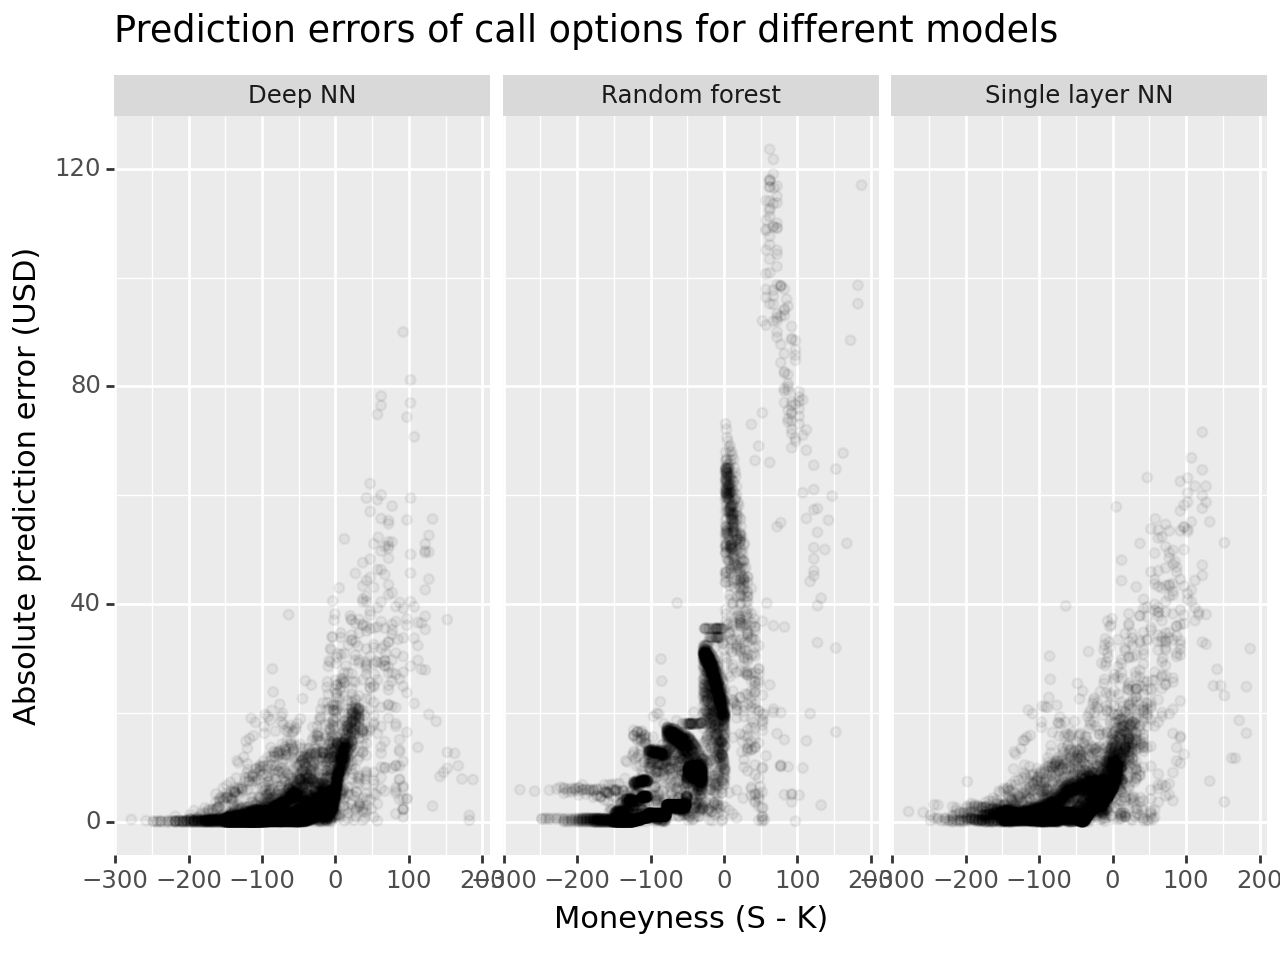

In [115]:
# Predictions evaluations
test_X = test_data.get(predictor_cols)
test_y = test_data.get("observed_price")

# Initiate dictionary for predictions
predictions = {}

# Check if predictions exist for each model before adding them to the dictionary
if fit_RF:
    predictions["Random forest"] = rf_fit.predict(test_X)

if fit_NNet:
    predictions["Single layer NN"] = nnet_fit.predict(test_X)

if fit_deepNNet:
    predictions["Deep NN"] = deepnnet_fit.predict(test_X)

# Create dataframe from predictions to be used in evaluation
predictions_df = pd.DataFrame(predictions)


predictive_performance = (pd.concat(
    [test_data.reset_index(drop=True), 
     predictions_df
    ], axis=1)
  .melt(
    id_vars=list(train_data.columns),
    var_name="Model",
    value_name="Predicted"
  )
  .assign(
      moneyness=lambda x: x["S"]-x["K"],
      pricing_error=lambda x: np.abs(x["Predicted"]-x["observed_price"]),
      relative_error = lambda x: (x['Predicted'] - x['observed_price']) / x['observed_price']
  )
)

predictive_performance_plot = (
  ggplot(predictive_performance, 
         aes(x="moneyness", y="pricing_error")) +
  geom_point(alpha=0.05) +
  facet_wrap("Model") + 
  labs(x="Moneyness (S - K)", y="Absolute prediction error (USD)",
       title="Prediction errors of call options for different models") +
  theme(legend_position="")
)
predictive_performance_plot.draw()

In [116]:
save_plot = False

if save_plot:
    # Define the filename and path where you want to save the plot
    file_path = f'figures/{evalDate}_predictive_performance_plot.png'
    
    # Save the plot to the specified file
    predictive_performance_plot.save(filename=file_path, dpi=300)

/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


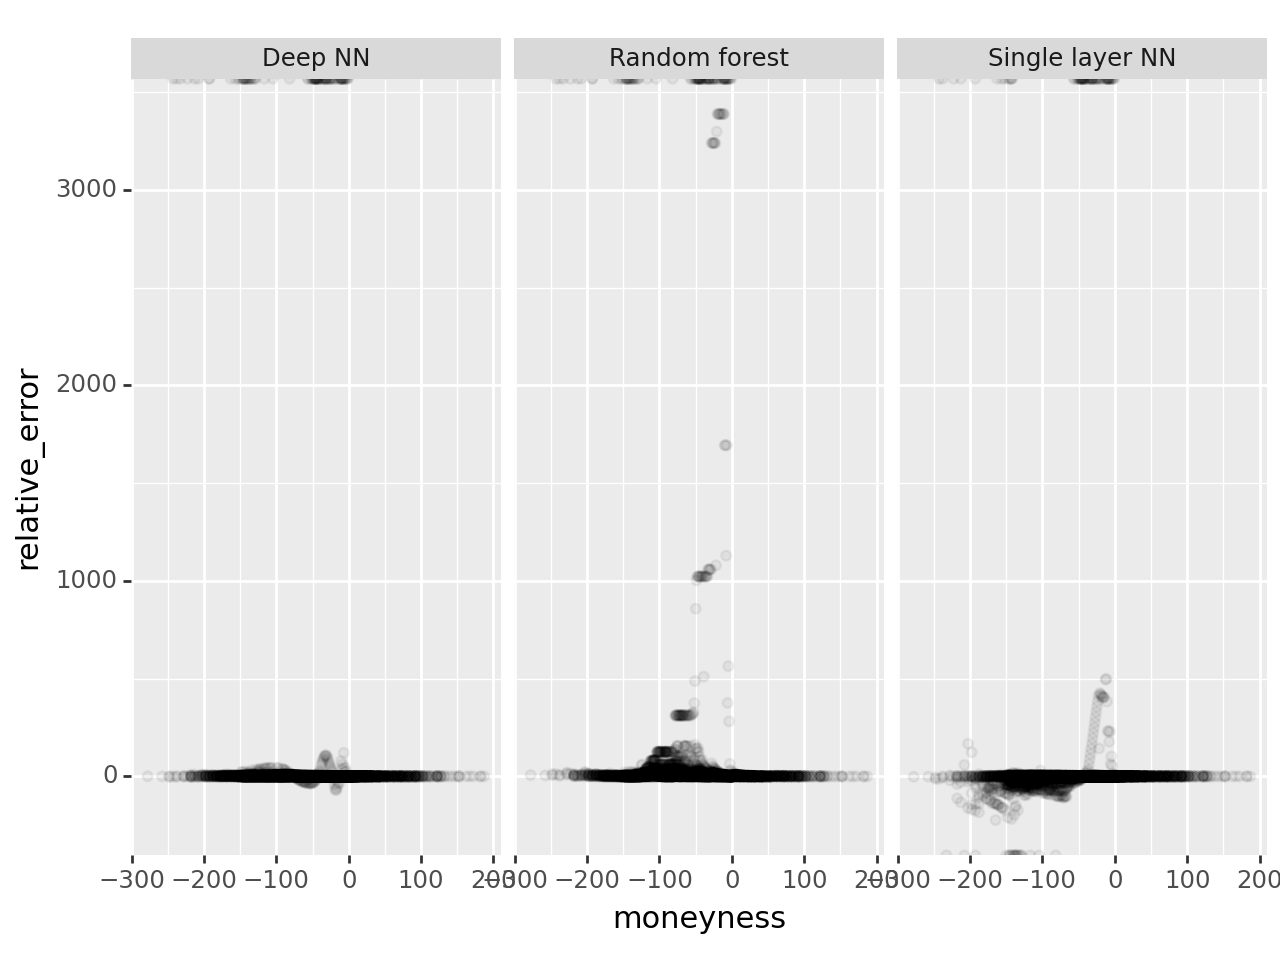

In [117]:
(ggplot(predictive_performance, 
         aes(x="moneyness", y="relative_error")) +
  geom_point(alpha=0.05) +
  facet_wrap("Model")
).draw()

/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


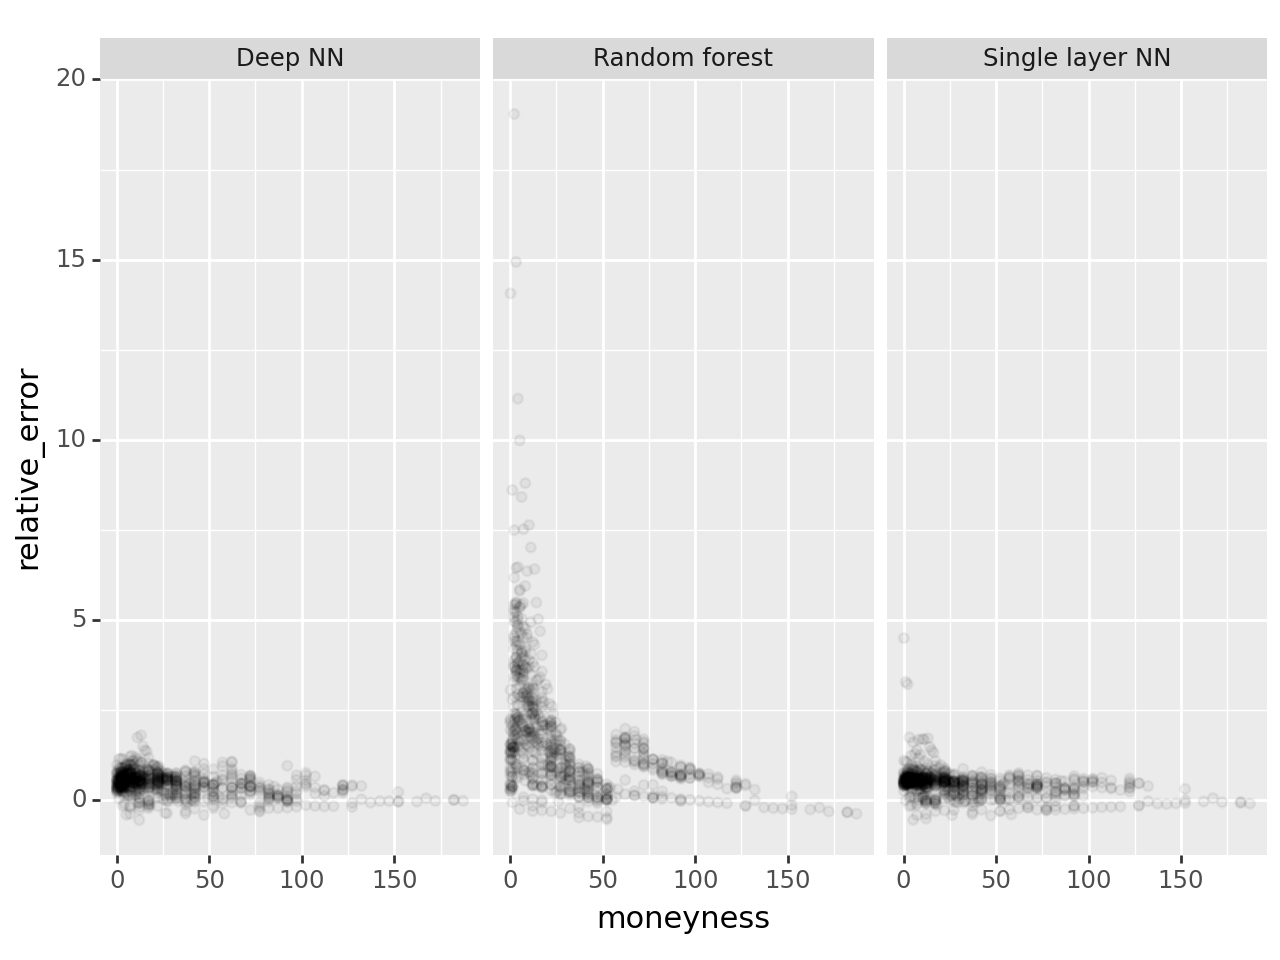

In [118]:
(ggplot(predictive_performance.query('(moneyness>0)'), 
         aes(x="moneyness", y="relative_error")) +
  geom_point(alpha=0.05) +
  facet_wrap("Model")
).draw()

/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


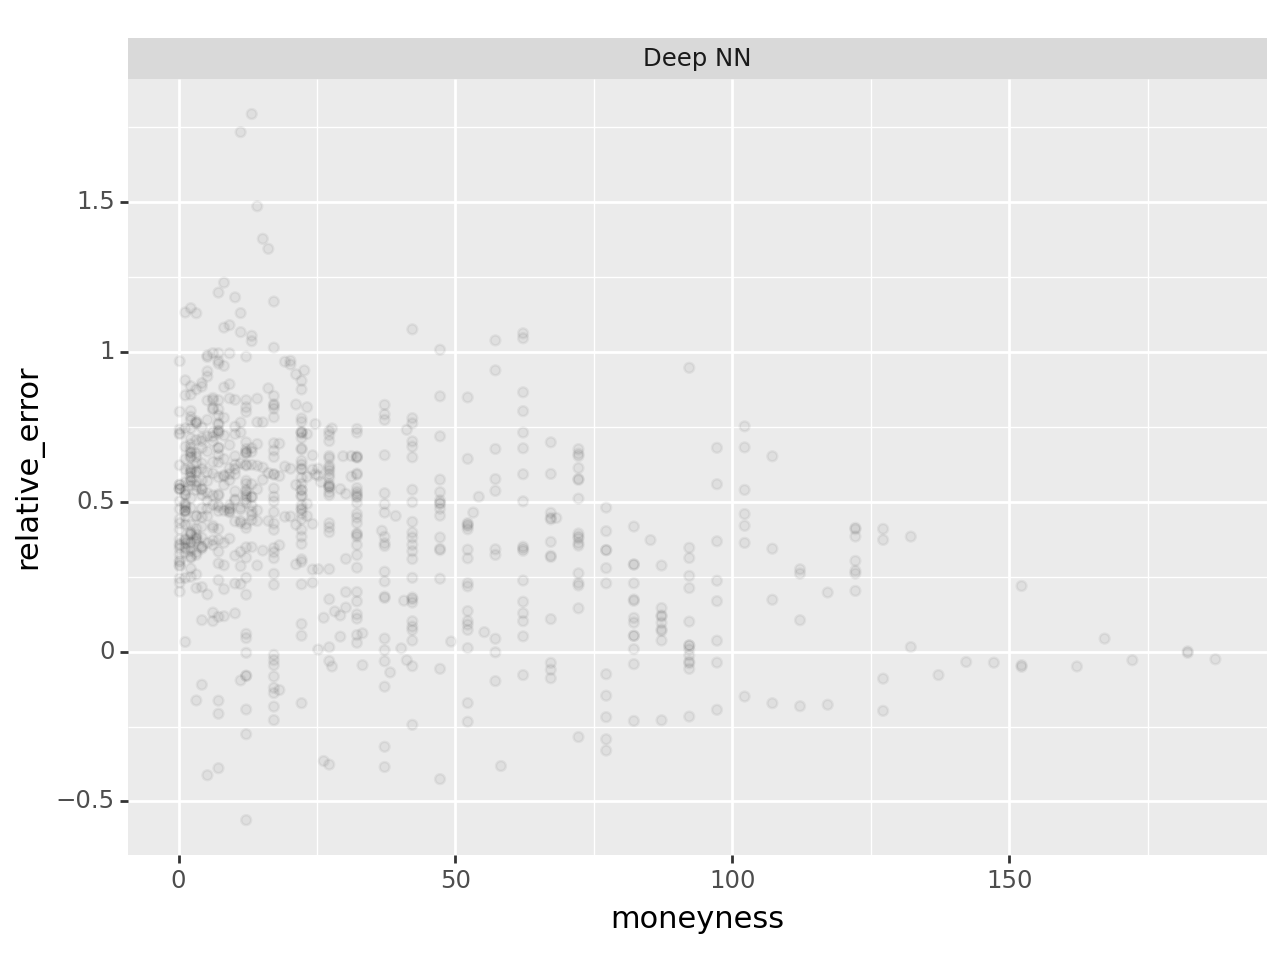

In [119]:
(ggplot(predictive_performance.query('(moneyness>0) & (Model == "Deep NN")'), 
         aes(x="moneyness", y="relative_error")) +
  geom_point(alpha=0.05) +
  facet_wrap("Model")
).draw()

/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


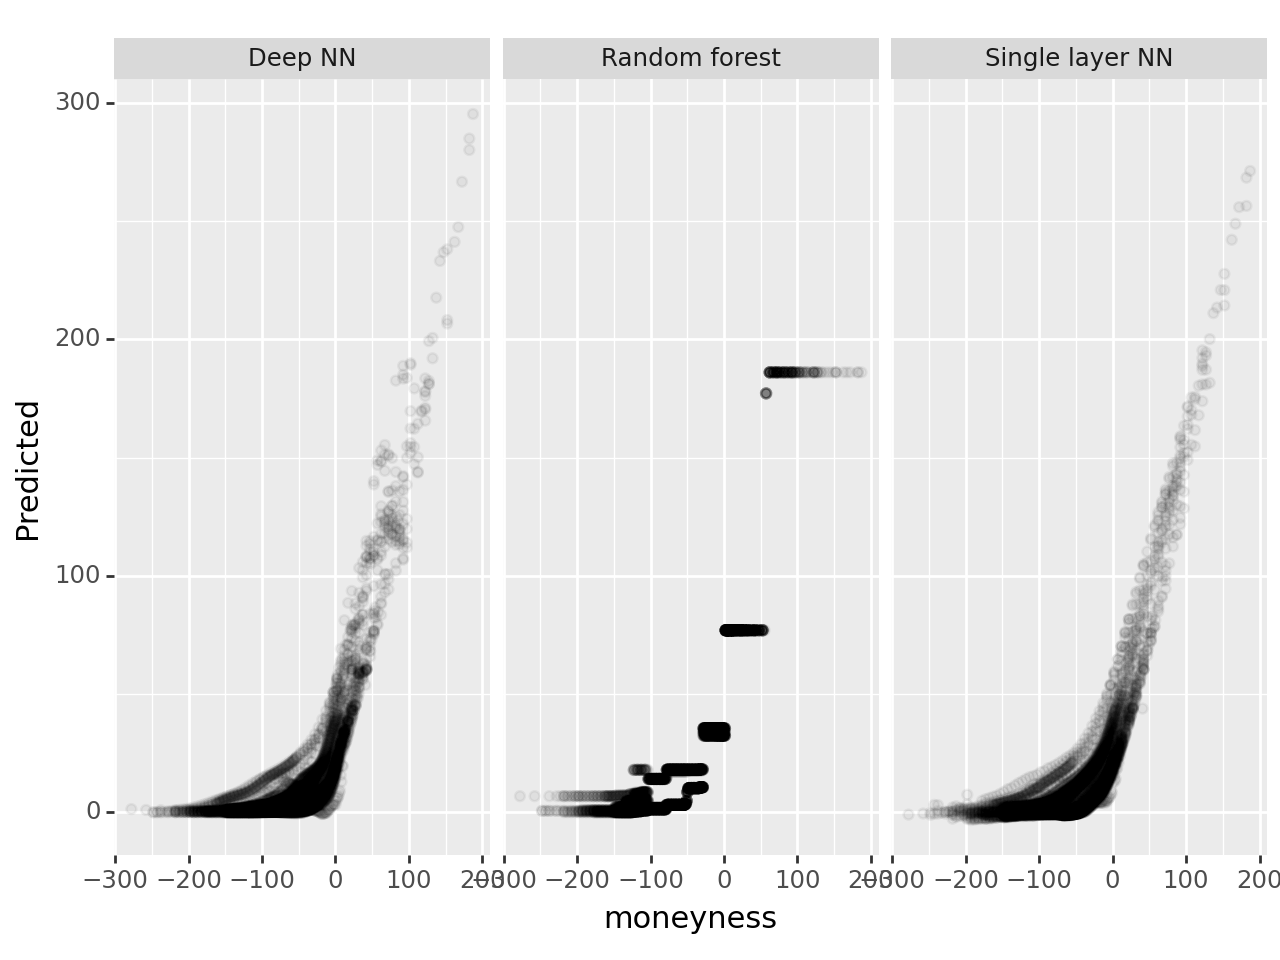

In [120]:
(ggplot(predictive_performance, 
         aes(x="moneyness", y="Predicted")) +
  geom_point(alpha=0.05) +
  facet_wrap("Model")
).draw()

/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


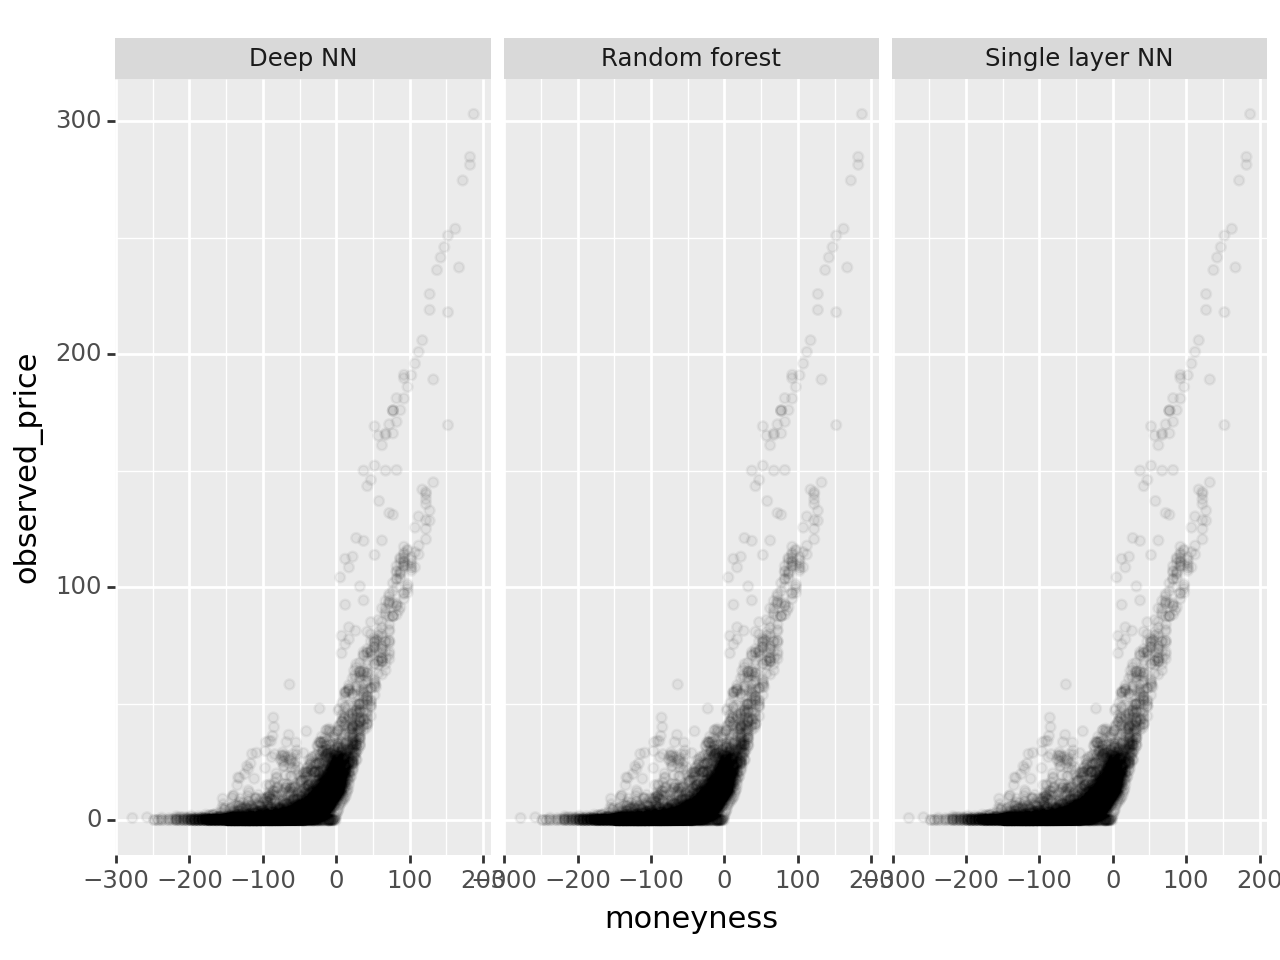

In [121]:
(ggplot(predictive_performance, 
         aes(x="moneyness", y="observed_price")) +
  geom_point(alpha=0.05) +
  facet_wrap("Model")
).draw()

/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


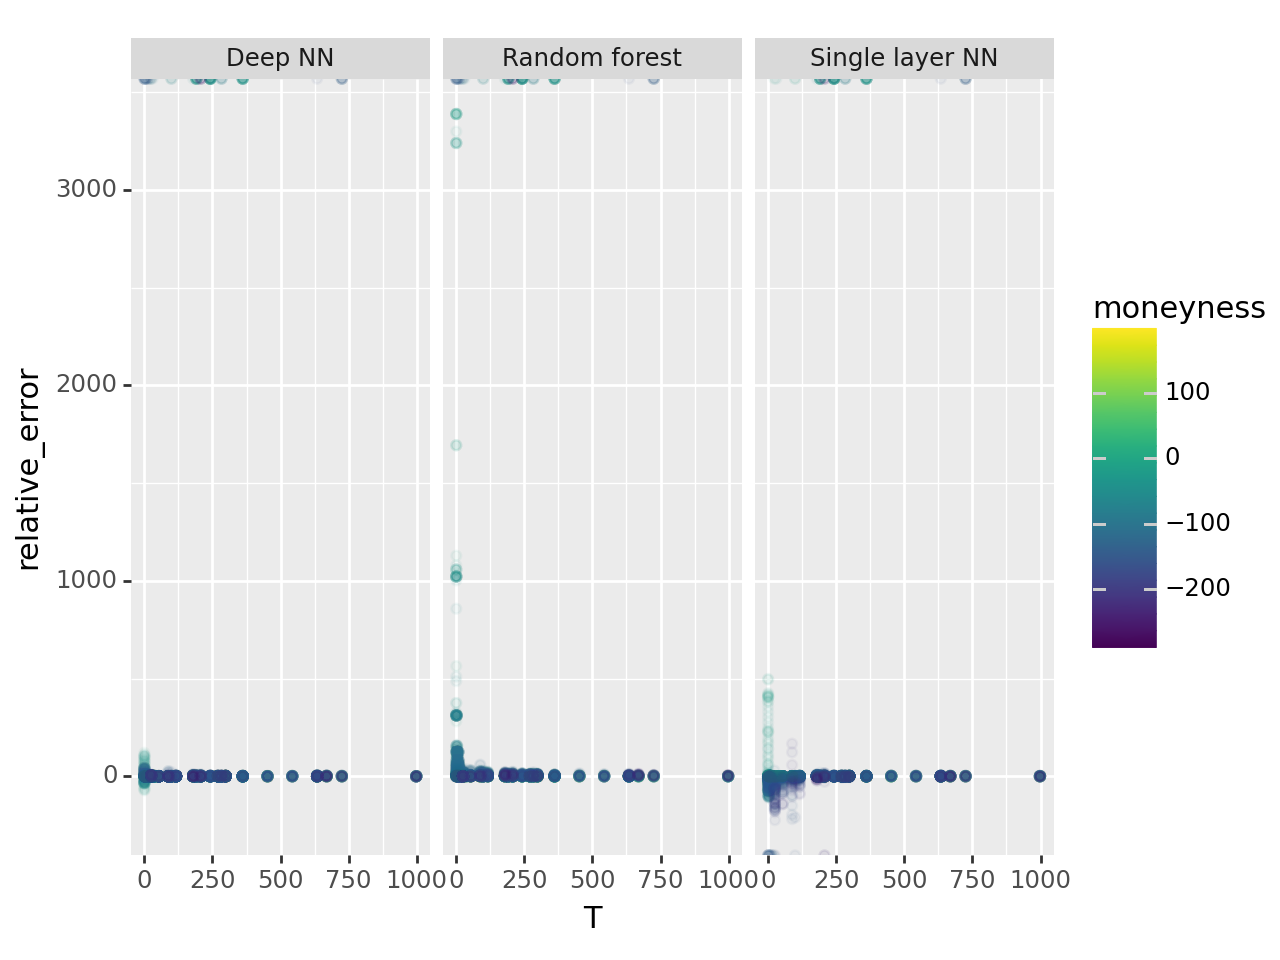

In [122]:
(ggplot(predictive_performance, 
         aes(x="T", y="relative_error",color="moneyness")) +
  geom_point(alpha=0.05) +
  facet_wrap("Model")
).draw()

/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/anaconda3/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


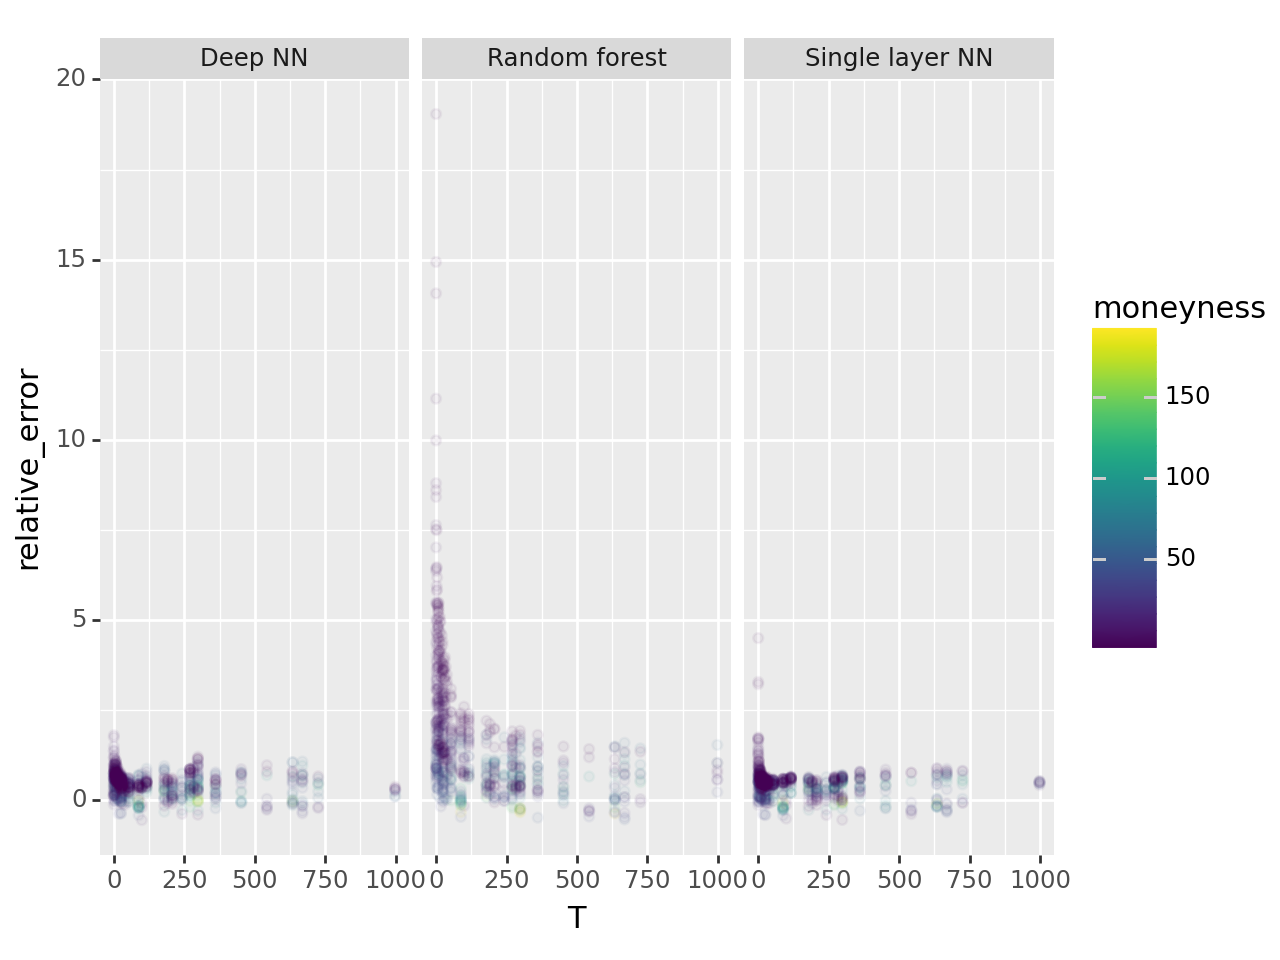

In [123]:
(ggplot(predictive_performance.query('(moneyness>0)'), 
         aes(x="T", y="relative_error",color="moneyness")) +
  geom_point(alpha=0.05) +
  facet_wrap("Model")
).draw()